##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Paper experiments for "Learning generalized Gumbel-max causal mechanisms"

This notebook shows how to reproduce the experiments for Section 7.1 and the first part of Section 7.2 (the first two columns of Table 1).

## Setting up the environment

In [ ]:
# Download the codebase
!git clone https://github.com/google-research/google-research.git --depth=1

Cloning into 'google-research'...
remote: Enumerating objects: 10043, done.
remote: Counting objects: 100% (10043/10043), done.
remote: Compressing objects: 100% (8038/8038), done.
remote: Total 10043 (delta 1443), reused 7963 (delta 1209), pack-reused 0
Receiving objects: 100% (10043/10043), 109.57 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (1443/1443), done.
Checking out files: 100% (10525/10525), done.


In [ ]:
import os
os.chdir("google-research")

In [ ]:
# Install Python packages
!pip install flax optax

In [ ]:
# See https://github.com/google/jax/blob/master/cloud_tpu_colabs/JAX_demo.ipynb
import requests
import os

if 'COLAB_TPU_ADDR' not in os.environ:
  raise RuntimeError("Please connect to a TPU runtime first!")

if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# Use TPU Driver as JAX's backend.
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

grpc://10.48.40.138:8470


In [ ]:
import jax
print(jax.devices())

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]

## Imports and configuration

In [ ]:
import functools
import time
from typing import *

import numpy as np
import jax
import jax.numpy as jnp
import optax
import flax
import flax.linen as nn

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.ion()
np.set_printoptions(linewidth=150)

In [ ]:
from gumbel_max_causal_gadgets import coupling_util
from gumbel_max_causal_gadgets import gadget_1
from gumbel_max_causal_gadgets import gadget_2
from gumbel_max_causal_gadgets import experiment_util

## Section 7.1: Optimizing for Maximality

In [ ]:
def perturbed_range_logit_pair_distribution_fn(rng, dim, base_scale=.1, noise_scale=.1):
  p_rng, q_rng = jax.random.split(rng, 2)
  p_base = jnp.arange(dim) - (dim - 1.0) / 2
  q_base = -p_base
  p_logits = base_scale * p_base + noise_scale * jax.random.normal(p_rng, (dim,))
  q_logits = base_scale * q_base + noise_scale * jax.random.normal(q_rng, (dim,))
  return p_logits, q_logits

def maximal_coupling_loss_matrix_fn(logits1, logits2):
  return 1.0 - jnp.eye(logits1.shape[0])

In [ ]:
experiments = []
S_dim = 10
Z_dim = 100
for lr in [1e-5]: # 3e-5,
  for noise_scale in [0, .1, .4, 1.6, 6.4, 25.6, 102.4]:
    for train_seed in [1, 2, 3, 4, 5]:
      ex = experiment_util.CouplingExperimentConfig(
        name=f"noise_scale={noise_scale} Z_dim={Z_dim} lr={lr} train_seed={train_seed}",
        model=(
            gadget_2.GadgetTwoMLPPredictor(
                S_dim=S_dim,
                Z_dim=Z_dim,
                hidden_features=[1024, 1024],
                relaxation_temperature=1.0,
                learn_prior=False)
        ),
        logit_pair_distribution_fn=functools.partial(
            perturbed_range_logit_pair_distribution_fn,
            dim=S_dim,
            base_scale=.1,
            noise_scale=noise_scale),
        coupling_loss_matrix_fn=maximal_coupling_loss_matrix_fn,
        inner_num_samples=16,
        batch_size=64,
        use_transpose=False,
        tx=optax.adam(lr),
        num_steps=10_000,
        print_every=1000,
        metadata={"train_seed": train_seed},
      )
      experiments.append(ex)


In [ ]:
results = []
test_results = []
for ex in experiments:
  print("=" * 20)
  print(f"Training: {ex.name}")
  res = ex.train(jax.random.PRNGKey(ex.metadata["train_seed"]))
  results.append(res)
  time.sleep(0.5)
  (logits_1, logits_2), couplings = experiment_util.get_coupling_estimates(
      [ex], [res], 1000 + ex.metadata["train_seed"],
      num_joint_samples=100_000,
      logit_kwargs={"noise_scale":0.0})
  test_loss = experiment_util.compute_coupling_losses([ex], logits_1, logits_2, couplings)
  print(test_loss)
  test_results.append((test_loss, logits_1, logits_2, couplings))

Training: noise_scale=0 Z_dim=100 lr=1e-05 train_seed=1
0 [0.12528412777995082/s]: {'loss': 0.6778644919395447}
1 [41.9103499270569/s]: {'loss': 0.6867863535881042}
2 [42.555412384208765/s]: {'loss': 0.691532552242279}
4 [75.78948890073453/s]: {'loss': 0.6750220060348511}
8 [122.07737701100916/s]: {'loss': 0.6820454001426697}
16 [176.57067682625214/s]: {'loss': 0.6700646877288818}
32 [231.5991482694478/s]: {'loss': 0.6719938516616821}
64 [266.8015632267991/s]: {'loss': 0.6711649894714355}
128 [298.75290032497884/s]: {'loss': 0.6443466544151306}
256 [305.49871255674/s]: {'loss': 0.5457638502120972}
512 [323.0133210354194/s]: {'loss': 0.35362526774406433}
1000 [339.0795859983457/s]: {'loss': 0.3099435567855835}
1024 [264.1845504600639/s]: {'loss': 0.3029372990131378}
2000 [329.923026570403/s]: {'loss': 0.3016328513622284}
2048 [276.96791421044304/s]: {'loss': 0.3214965760707855}
3000 [324.09867979973137/s]: {'loss': 0.28353044390678406}
4000 [320.81498539495055/s]: {'loss': 0.27721697092

In [ ]:
import collections
import re

table = collections.defaultdict(lambda: collections.defaultdict(list))
for task_results in test_results:
  for name, loss in task_results[0].items():
    if name.startswith('noise_scale'):# and "lr=1e-05" in name:
      m = re.search('noise_scale=(\S+) Z_dim=(\S+)', name)
      if m is not None:
        noise_scale, Z_dim = m.groups()
        table[Z_dim][float(noise_scale)].append(float(loss))
table

{'100': {0.0:
           [0.2481900006532669,
            0.24666999280452728,
            0.24633999168872833,
            0.2475000023841858,
            0.24786999821662903],
         0.1:
           [0.26311996579170227,
            0.2629200220108032,
            0.26527997851371765,
            0.2658500075340271,
            0.2668899893760681],
         0.4:
           [0.2709300220012665,
            0.2709999680519104,
            0.2707799971103668,
            0.2703399956226349,
            0.2741200029850006],
         1.6:
           [0.2830600142478943,
            0.2836900055408478,
            0.2833099961280823,
            0.28325000405311584,
            0.2790599763393402],
         6.4:
           [0.29815003275871277,
            0.29875001311302185,
            0.2984599769115448,
            0.29992997646331787,
            0.2982199490070343],
         25.6:
           [0.29580003023147583,
            0.2984299957752228,
            0.29791998863220215,
            0.29704996943473816,
            0.29670995473861694],
         102.4:
           [0.30053001642227173,
            0.301179975271225,
            0.29802995920181274,
            0.2935200035572052,
            0.2975099980831146]}}

In [ ]:
noise_scales, losses = zip(*table['100'].items())
noise_scales, losses

((0.0, 0.1, 0.4, 1.6, 6.4, 25.6, 102.4),
 ([0.2481900006532669,
   0.24666999280452728,
   0.24633999168872833,
   0.2475000023841858,
   0.24786999821662903],
  [0.26311996579170227,
   0.2629200220108032,
   0.26527997851371765,
   0.2658500075340271,
   0.2668899893760681],
  [0.2709300220012665,
   0.2709999680519104,
   0.2707799971103668,
   0.2703399956226349,
   0.2741200029850006],
  [0.2830600142478943,
   0.2836900055408478,
   0.2833099961280823,
   0.28325000405311584,
   0.2790599763393402],
  [0.29815003275871277,
   0.29875001311302185,
   0.2984599769115448,
   0.29992997646331787,
   0.2982199490070343],
  [0.29580003023147583,
   0.2984299957752228,
   0.29791998863220215,
   0.29704996943473816,
   0.29670995473861694],
  [0.30053001642227173,
   0.301179975271225,
   0.29802995920181274,
   0.2935200035572052,
   0.2975099980831146]))

In [ ]:
losses = np.array(list(losses))
loss_avgs = np.mean(losses, axis=-1)
loss_stds = np.std(losses, axis=-1)

In [ ]:
_, logits_1, logits_2, _ = test_results[0]
score_matrix = maximal_coupling_loss_matrix_fn(logits_1, logits_2)

gumbel_max_coupling = coupling_util.joint_from_samples(
    coupling_util.gumbel_max_sampler,
    logits_1=logits_1,
    logits_2=logits_2,
    rng=jax.random.PRNGKey(0),
    num_samples=100_000)
gumbel_max_score = jnp.sum(score_matrix * gumbel_max_coupling)

maximal_coupling = coupling_util.joint_from_samples(
    coupling_util.maximal_coupling_sampler,
    logits_1=logits_1,
    logits_2=logits_2,
    rng=jax.random.PRNGKey(0),
    num_samples=100_000)
maximal_score = jnp.sum(score_matrix * maximal_coupling)

gumbel_max_score, maximal_score

(DeviceArray(0.29661, dtype=float32), DeviceArray(0.24342999, dtype=float32))

Text(0, 0.5, 'Coupling loss (test)')

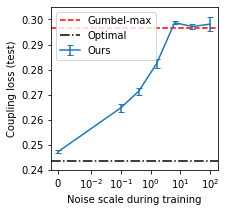

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.figure.set_dpi(300)

plt.errorbar(noise_scales, loss_avgs, yerr=loss_stds, capsize=3, label="Ours")
ax.set_xscale('symlog', linthreshx=.01)

plt.axhline(gumbel_max_score, c='r', ls='--', label="Gumbel-max")
plt.axhline(maximal_score, c='k', ls='-.', label="Optimal")

plt.legend(loc='upper left')
plt.ylim([.24, .305])

plt.xlabel('Noise scale during training')
plt.ylabel('Coupling loss (test)')

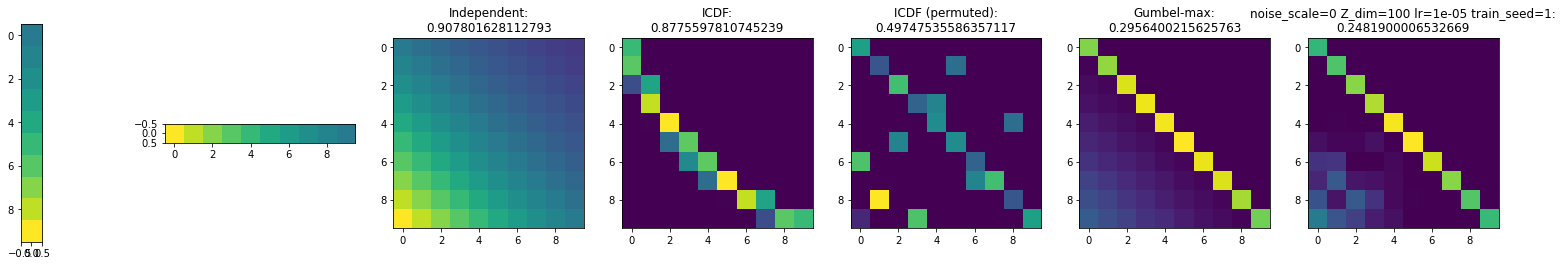

In [ ]:
i = 0
ex = experiments[i]
experiment_util.visualize_coupling_experiments(*test_results[i])

## Section 7.2 part 1: Minimizing variance with random p and q

In [ ]:
def softmax_uniform_logits(rng, dim=10):
  """Sample logits in a way that is sparse."""
  return jax.nn.log_softmax(8 * jax.random.uniform(rng, shape=[dim]))

def softmax_uniform_logit_pair_distribution_fn(key, dim, p_q_mode, fixed_p_q_seed=123456):
  if p_q_mode == "fixed":
    key = jax.random.PRNGKey(fixed_p_q_seed)
    key_p, key_q = jax.random.split(key, 2)
    p_logits = softmax_uniform_logits(key_p, dim)
    q_logits = softmax_uniform_logits(key_q, dim)
  elif p_q_mode == "independent":
    key_p, key_q = jax.random.split(key, 2)
    p_logits = softmax_uniform_logits(key_p, dim)
    q_logits = softmax_uniform_logits(key_q, dim)
  elif p_q_mode == "reverse":
    key_p = key
    p_logits = softmax_uniform_logits(key_p, dim)
    q_logits = p_logits[::-1]
  else:
    raise NotImplementedError(p_q_mode)

  return p_logits, q_logits

def squared_loss_matrix_fn(logits1, logits2):
  seq = jnp.arange(logits1.shape[0]).astype(jnp.float32)
  return jnp.square(seq[None, :] - seq[:, None])

### Phase 1: Tuning learning rate


In [ ]:
S_dim = 10
experiments = []
for lr in [1e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]:
  for p_q_mode in ["reverse", "independent", "fixed"]:
    for is_gadget_2 in [True, False]:
      ex = experiment_util.CouplingExperimentConfig(
        name=f"G{2 if is_gadget_2 else 1} relaxed {p_q_mode} lr={lr}",
        model=(
            gadget_2.GadgetTwoMLPPredictor(
                S_dim=10, Z_dim=20, hidden_features=[1024, 1024],
                relaxation_temperature=1.0, learn_prior=False)
            if is_gadget_2 else
            gadget_1.GadgetOneMLPPredictor(
                S_dim=10, hidden_features=[1024, 1024],
                relaxation_temperature=1.0)
        ),
        logit_pair_distribution_fn=functools.partial(
            softmax_uniform_logit_pair_distribution_fn,
            dim=S_dim,
            p_q_mode=p_q_mode),
        coupling_loss_matrix_fn=squared_loss_matrix_fn,
        inner_num_samples=16,
        batch_size=64,
        use_transpose=(not is_gadget_2),
        tx=optax.adam(lr),
        num_steps=5_000,
        print_every=2_500,
        metadata=dict(lr=lr, p_q_mode=p_q_mode, is_gadget_2=is_gadget_2),
      )
      experiments.append(ex)

In [ ]:
results = []
for ex in experiments:
  print("=" * 20)
  print(f"Training: {ex.name}")
  res = ex.train(jax.random.PRNGKey(0))
  time.sleep(0.1)
  client = jax.lib.xla_bridge.get_backend()
  client.defragment()
  results.append(res)

Training: G2 relaxed reverse lr=1e-05
0 [0.1565066369825618/s]: {'loss': 16.857027053833008}
1 [43.994042249680085/s]: {'loss': 18.300264358520508}
2 [44.8162070328778/s]: {'loss': 19.191816329956055}
4 [82.1993493513111/s]: {'loss': 17.70201873779297}
8 [143.8585527726092/s]: {'loss': 16.645944595336914}
16 [223.6619185058291/s]: {'loss': 15.625785827636719}
32 [317.49925011946044/s]: {'loss': 17.1085262298584}
64 [399.2032693463092/s]: {'loss': 18.833566665649414}
128 [459.67730257806545/s]: {'loss': 17.97404670715332}
256 [474.7053926059016/s]: {'loss': 16.608440399169922}
512 [521.4910965796723/s]: {'loss': 13.66977310180664}
1024 [532.6067293729577/s]: {'loss': 13.337252616882324}
2048 [537.3472031271718/s]: {'loss': 17.35462760925293}
2500 [528.2141091291661/s]: {'loss': 16.38849449157715}
4096 [535.3209017331111/s]: {'loss': 11.6572847366333}
Training: G1 relaxed reverse lr=1e-05
0 [0.525463461763966/s]: {'loss': 18.823545455932617}
1 [45.39781361619223/s]: {'loss': 20.674999237

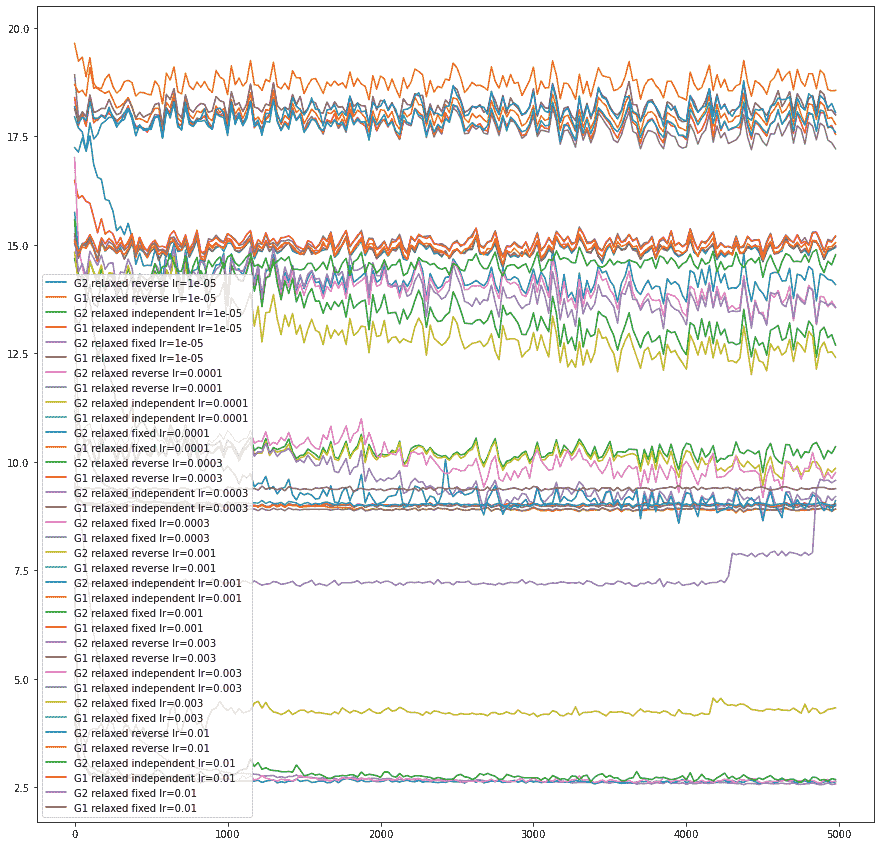

In [ ]:
plt.figure(figsize=(15,15))
WINDOW_SIZE = 25
for ex, res in zip(experiments, results):
  plt.plot(np.arange(0, ex.num_steps, WINDOW_SIZE), np.reshape([m["loss"] for m in res.all_metrics], [-1, WINDOW_SIZE]).mean(-1), label=ex.name)
plt.legend()

#### Extract subset for each mode

##### Independent

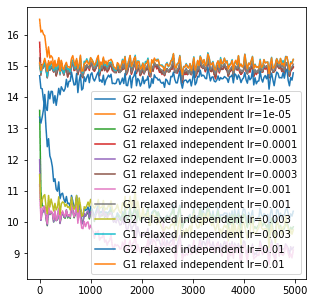

In [ ]:
indices = [i for i, ex in enumerate(experiments) if (ex.metadata["p_q_mode"] == "independent")]
plt.figure(figsize=(5,5))
WINDOW_SIZE = 25
for i in indices:
  plt.plot(np.arange(0, experiments[i].num_steps, WINDOW_SIZE), np.reshape([m["loss"] for m in results[i].all_metrics], [-1, WINDOW_SIZE]).mean(-1), label=experiments[i].name)
plt.legend()

In [ ]:
eval_results_independent = experiment_util.evaluate_all([experiments[i] for i in indices], [results[i] for i in indices],
                                    seed=765987, num_pairs=10_000, samples_per_pair=1_000, loop_size=500)

In [ ]:
{k:summary for k, (summary, _, _, _) in eval_results_independent.items()}

{'Independent': 'average: 16.4429, inner st.dev.: +/- 18.01, errorbars: +/- 0.0716',
 'ICDF': 'average: 8.0650, inner st.dev.: +/- 9.236, errorbars: +/- 0.0710',
 'ICDF (permuted)': 'average: 15.5358, inner st.dev.: +/- 17.8, errorbars: +/- 0.0866',
 'Gumbel-max': 'average: 13.9369, inner st.dev.: +/- 17.36, errorbars: +/- 0.0724',
 'G2 relaxed independent lr=1e-05':
   'average: 9.6486, inner st.dev.: +/- 12.21, errorbars: +/- 0.0700',
 'G1 relaxed independent lr=1e-05':
   'average: 14.0209, inner st.dev.: +/- 17.02, errorbars: +/- 0.0707',
 'G2 relaxed independent lr=0.0001':
   'average: 9.3079, inner st.dev.: +/- 11.64, errorbars: +/- 0.0698',
 'G1 relaxed independent lr=0.0001':
   'average: 13.9911, inner st.dev.: +/- 17.15, errorbars: +/- 0.0714',
 'G2 relaxed independent lr=0.0003':
   'average: 8.8592, inner st.dev.: +/- 10.85, errorbars: +/- 0.0704',
 'G1 relaxed independent lr=0.0003':
   'average: 14.0315, inner st.dev.: +/- 17.02, errorbars: +/- 0.0712',
 'G2 relaxed independent lr=0.001':
   'average: 8.8147, inner st.dev.: +/- 10.73, errorbars: +/- 0.0705',
 'G1 relaxed independent lr=0.001':
   'average: 14.1306, inner st.dev.: +/- 16.77, errorbars: +/- 0.0696',
 'G2 relaxed independent lr=0.003':
   'average: 9.2065, inner st.dev.: +/- 11.6, errorbars: +/- 0.0710',
 'G1 relaxed independent lr=0.003':
   'average: 14.3617, inner st.dev.: +/- 16.94, errorbars: +/- 0.0702',
 'G2 relaxed independent lr=0.01':
   'average: 13.8375, inner st.dev.: +/- 17.28, errorbars: +/- 0.0716',
 'G1 relaxed independent lr=0.01':
   'average: 14.3397, inner st.dev.: +/- 17.09, errorbars: +/- 0.0707'}

In [ ]:
lr_bests = {}
for i in indices:
  ex = experiments[i]
  shortname = ex.name.split(" lr=")[0]
  if shortname not in lr_bests or eval_results_independent[ex.name][1] < lr_bests[shortname][2]:
    lr_bests[shortname] = (ex.name, i, eval_results_independent[ex.name][1])

lr_best_subset = [i for _, i, _ in lr_bests.values()]
lr_best_subset_independent = lr_best_subset
lr_bests

{'G2 relaxed independent':
   ('G2 relaxed independent lr=0.001',
    20,
    DeviceArray(8.814732, dtype=float32)),
 'G1 relaxed independent':
   ('G1 relaxed independent lr=0.0001',
    9,
    DeviceArray(13.991138, dtype=float32))}

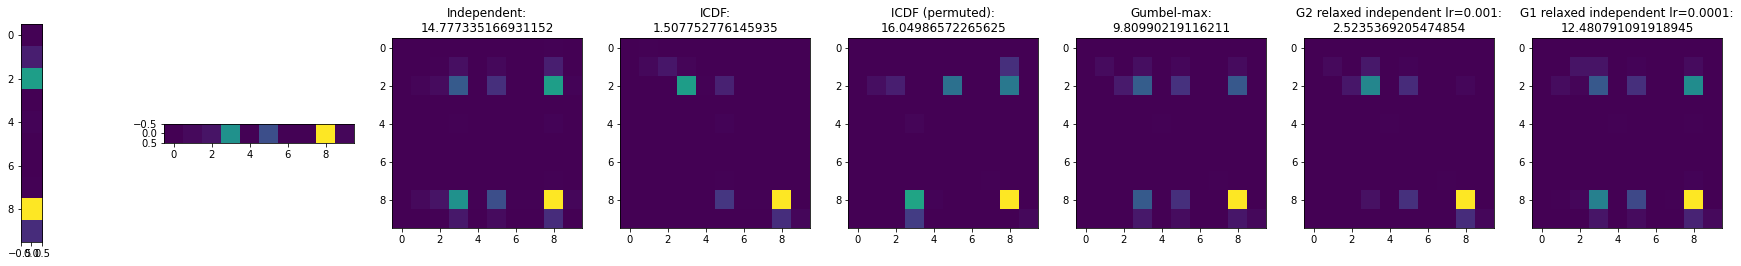

In [ ]:
experiment_util.compute_and_visualize_coupling_experiments([experiments[i] for i in lr_best_subset_independent], [results[i] for i in lr_best_subset_independent], 1)

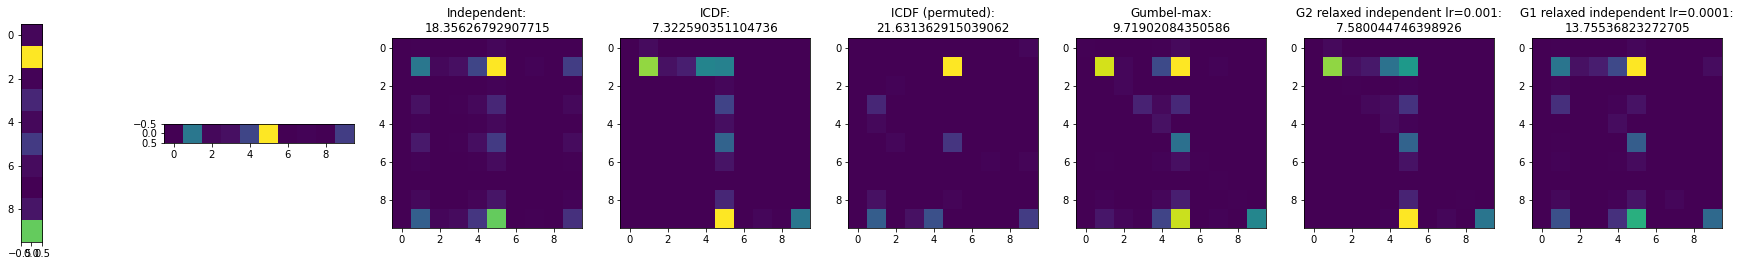

In [ ]:
experiment_util.compute_and_visualize_coupling_experiments([experiments[i] for i in lr_best_subset_independent], [results[i] for i in lr_best_subset_independent], 2)

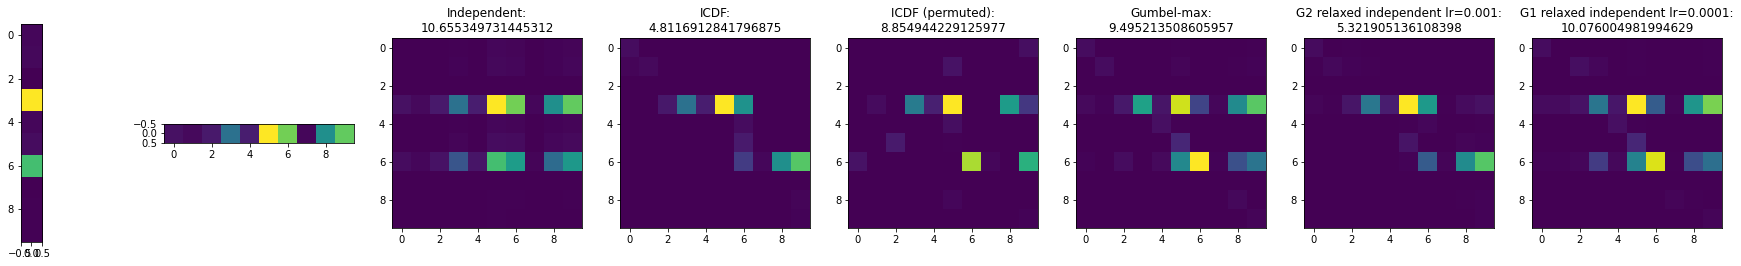

In [ ]:
experiment_util.compute_and_visualize_coupling_experiments([experiments[i] for i in lr_best_subset_independent], [results[i] for i in lr_best_subset_independent], 3)

##### Reverse

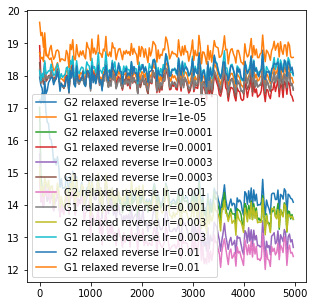

In [ ]:
indices = [i for i, ex in enumerate(experiments) if (ex.metadata["p_q_mode"] == "reverse")]
plt.figure(figsize=(5,5))
WINDOW_SIZE = 25
for i in indices:
  plt.plot(np.arange(0, experiments[i].num_steps, WINDOW_SIZE), np.reshape([m["loss"] for m in results[i].all_metrics], [-1, WINDOW_SIZE]).mean(-1), label=experiments[i].name)
plt.legend()

In [ ]:
eval_results_reverse = experiment_util.evaluate_all([experiments[i] for i in indices], [results[i] for i in indices],
                                    seed=765987, num_pairs=10_000, samples_per_pair=1_000, loop_size=500)

In [ ]:
{k:summary for k, (summary, _, _, _) in eval_results_reverse.items()}

{'Independent': 'average: 21.4180, inner st.dev.: +/- 20.51, errorbars: +/- 0.1233',
 'ICDF': 'average: 12.7086, inner st.dev.: +/- 11.89, errorbars: +/- 0.1325',
 'ICDF (permuted)': 'average: 21.0385, inner st.dev.: +/- 20.6, errorbars: +/- 0.1459',
 'Gumbel-max': 'average: 18.9085, inner st.dev.: +/- 20.18, errorbars: +/- 0.1273',
 'G2 relaxed reverse lr=1e-05':
   'average: 14.2178, inner st.dev.: +/- 14.44, errorbars: +/- 0.1292',
 'G1 relaxed reverse lr=1e-05':
   'average: 18.7739, inner st.dev.: +/- 19.54, errorbars: +/- 0.1242',
 'G2 relaxed reverse lr=0.0001':
   'average: 13.8670, inner st.dev.: +/- 13.9, errorbars: +/- 0.1300',
 'G1 relaxed reverse lr=0.0001':
   'average: 17.6351, inner st.dev.: +/- 18.62, errorbars: +/- 0.1232',
 'G2 relaxed reverse lr=0.0003':
   'average: 13.6066, inner st.dev.: +/- 13.27, errorbars: +/- 0.1312',
 'G1 relaxed reverse lr=0.0003':
   'average: 18.1914, inner st.dev.: +/- 19.04, errorbars: +/- 0.1260',
 'G2 relaxed reverse lr=0.001':
   'average: 13.5656, inner st.dev.: +/- 13.05, errorbars: +/- 0.1316',
 'G1 relaxed reverse lr=0.001':
   'average: 18.3887, inner st.dev.: +/- 19.05, errorbars: +/- 0.1228',
 'G2 relaxed reverse lr=0.003':
   'average: 13.7463, inner st.dev.: +/- 13.78, errorbars: +/- 0.1317',
 'G1 relaxed reverse lr=0.003':
   'average: 19.1777, inner st.dev.: +/- 19.67, errorbars: +/- 0.1224',
 'G2 relaxed reverse lr=0.01':
   'average: 18.9606, inner st.dev.: +/- 20.16, errorbars: +/- 0.1267',
 'G1 relaxed reverse lr=0.01':
   'average: 19.9766, inner st.dev.: +/- 19.69, errorbars: +/- 0.1239'}

In [ ]:
lr_bests = {}
for i in indices:
  ex = experiments[i]
  shortname = ex.name.split(" lr=")[0]
  if shortname not in lr_bests or eval_results_reverse[ex.name][1] < lr_bests[shortname][2]:
    lr_bests[shortname] = (ex.name, i, eval_results_reverse[ex.name][1])

lr_best_subset = [i for _, i, _ in lr_bests.values()]
lr_best_subset_reverse = lr_best_subset
lr_bests

{'G2 relaxed reverse': ('G2 relaxed reverse lr=0.001',
                        18,
                        DeviceArray(13.56559, dtype=float32)),
 'G1 relaxed reverse': ('G1 relaxed reverse lr=0.0001',
                        7,
                        DeviceArray(17.635136, dtype=float32))}

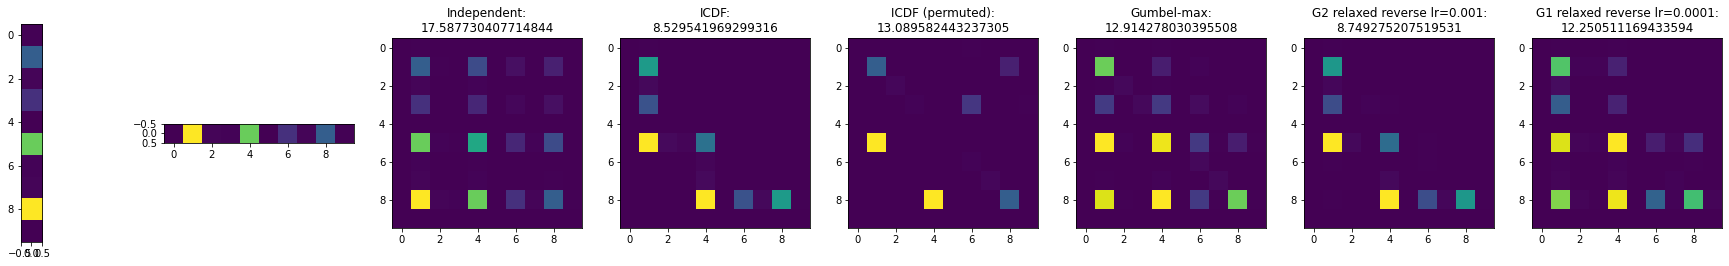

In [ ]:
experiment_util.compute_and_visualize_coupling_experiments([experiments[i] for i in lr_best_subset_reverse], [results[i] for i in lr_best_subset_reverse], 1)

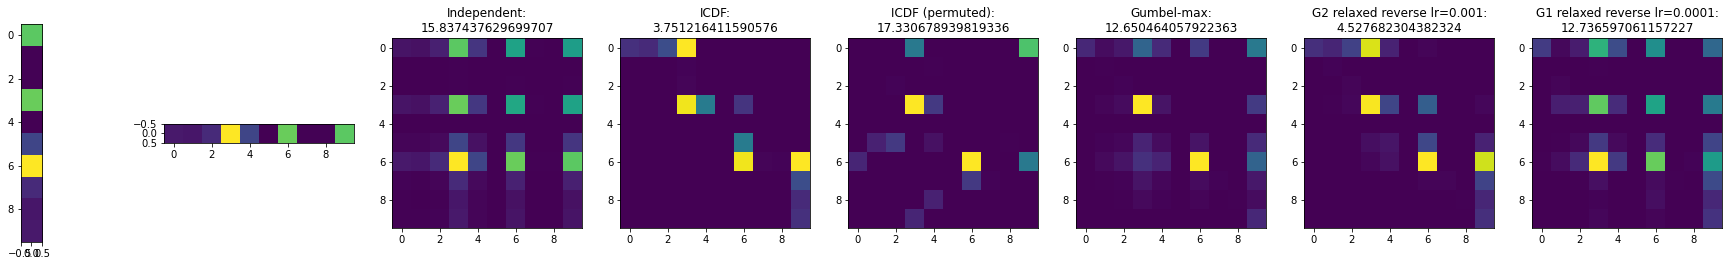

In [ ]:
experiment_util.compute_and_visualize_coupling_experiments([experiments[i] for i in lr_best_subset_reverse], [results[i] for i in lr_best_subset_reverse], 2)

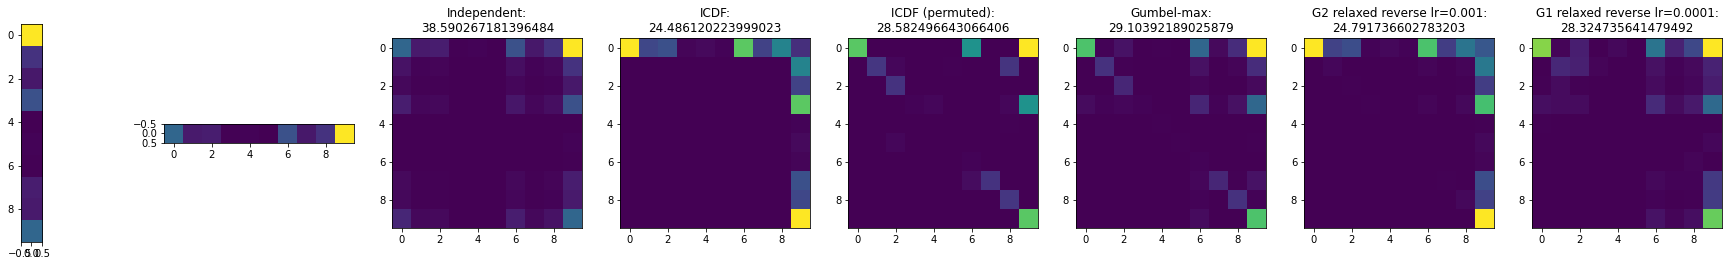

In [ ]:
experiment_util.compute_and_visualize_coupling_experiments([experiments[i] for i in lr_best_subset_reverse], [results[i] for i in lr_best_subset_reverse], 3)

##### Fixed

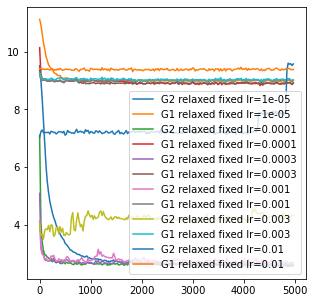

In [ ]:
indices = [i for i, ex in enumerate(experiments) if (ex.metadata["p_q_mode"] == "fixed")]
plt.figure(figsize=(5,5))
WINDOW_SIZE = 25
for i in indices:
  plt.plot(np.arange(0, experiments[i].num_steps, WINDOW_SIZE), np.reshape([m["loss"] for m in results[i].all_metrics], [-1, WINDOW_SIZE]).mean(-1), label=experiments[i].name)
plt.legend()

In [ ]:
eval_results_fixed = experiment_util.evaluate_all([experiments[i] for i in indices], [results[i] for i in indices],
                                    seed=765987, num_pairs=1, samples_per_pair=100_000, loop_size=500)

In [ ]:
{k:summary for k, (summary, _, _, _) in eval_results_fixed.items()}

{'Independent': 'average: 10.1531, inner st.dev.: +/- 12.39, errorbars: +/- 0.0000',
 'ICDF': 'average: 2.8793, inner st.dev.: +/- 3.471, errorbars: +/- 0.0000',
 'ICDF (permuted)': 'average: 7.4976, inner st.dev.: +/- 8.426, errorbars: +/- 0.0000',
 'Gumbel-max': 'average: 7.0582, inner st.dev.: +/- 11.06, errorbars: +/- 0.0000',
 'G2 relaxed fixed lr=1e-05':
   'average: 3.1299, inner st.dev.: +/- 3.782, errorbars: +/- 0.0000',
 'G1 relaxed fixed lr=1e-05':
   'average: 5.2283, inner st.dev.: +/- 6.521, errorbars: +/- 0.0000',
 'G2 relaxed fixed lr=0.0001':
   'average: 3.1479, inner st.dev.: +/- 3.794, errorbars: +/- 0.0000',
 'G1 relaxed fixed lr=0.0001':
   'average: 4.8208, inner st.dev.: +/- 5.569, errorbars: +/- 0.0000',
 'G2 relaxed fixed lr=0.0003':
   'average: 3.1748, inner st.dev.: +/- 3.809, errorbars: +/- 0.0000',
 'G1 relaxed fixed lr=0.0003':
   'average: 4.9635, inner st.dev.: +/- 5.563, errorbars: +/- 0.0000',
 'G2 relaxed fixed lr=0.001':
   'average: 3.1618, inner st.dev.: +/- 3.789, errorbars: +/- 0.0000',
 'G1 relaxed fixed lr=0.001':
   'average: 5.3675, inner st.dev.: +/- 6.529, errorbars: +/- 0.0000',
 'G2 relaxed fixed lr=0.003':
   'average: 3.6700, inner st.dev.: +/- 5.817, errorbars: +/- 0.0000',
 'G1 relaxed fixed lr=0.003':
   'average: 5.3996, inner st.dev.: +/- 6.936, errorbars: +/- 0.0000',
 'G2 relaxed fixed lr=0.01':
   'average: 7.3154, inner st.dev.: +/- 11.39, errorbars: +/- 0.0000',
 'G1 relaxed fixed lr=0.01':
   'average: 6.3977, inner st.dev.: +/- 9.596, errorbars: +/- 0.0000'}

In [ ]:
{k:(isd/np.sqrt(100_000)) for k, (_, _, _, isd) in eval_results_fixed.items()}

{'Independent': DeviceArray(0.03916968, dtype=float32),
 'ICDF': DeviceArray(0.0109747, dtype=float32),
 'ICDF (permuted)': DeviceArray(0.02664398, dtype=float32),
 'Gumbel-max': DeviceArray(0.0349714, dtype=float32),
 'G2 relaxed fixed lr=1e-05': DeviceArray(0.01196018, dtype=float32),
 'G1 relaxed fixed lr=1e-05': DeviceArray(0.02062217, dtype=float32),
 'G2 relaxed fixed lr=0.0001': DeviceArray(0.01199626, dtype=float32),
 'G1 relaxed fixed lr=0.0001': DeviceArray(0.01761122, dtype=float32),
 'G2 relaxed fixed lr=0.0003': DeviceArray(0.01204557, dtype=float32),
 'G1 relaxed fixed lr=0.0003': DeviceArray(0.01759123, dtype=float32),
 'G2 relaxed fixed lr=0.001': DeviceArray(0.01198215, dtype=float32),
 'G1 relaxed fixed lr=0.001': DeviceArray(0.02064614, dtype=float32),
 'G2 relaxed fixed lr=0.003': DeviceArray(0.0183947, dtype=float32),
 'G1 relaxed fixed lr=0.003': DeviceArray(0.02193438, dtype=float32),
 'G2 relaxed fixed lr=0.01': DeviceArray(0.03602124, dtype=float32),
 'G1 relaxed fixed lr=0.01': DeviceArray(0.03034677, dtype=float32)}

In [ ]:
lr_bests = {}
for i in indices:
  ex = experiments[i]
  shortname = ex.name.split(" lr=")[0]
  if shortname not in lr_bests or eval_results_fixed[ex.name][1] < lr_bests[shortname][2]:
    lr_bests[shortname] = (ex.name, i, eval_results_fixed[ex.name][1])

lr_best_subset = [i for _, i, _ in lr_bests.values()]
lr_best_subset_fixed = lr_best_subset
lr_bests

{'G2 relaxed fixed': ('G2 relaxed fixed lr=1e-05',
                      4,
                      DeviceArray(3.12986, dtype=float32)),
 'G1 relaxed fixed': ('G1 relaxed fixed lr=0.0001',
                      11,
                      DeviceArray(4.82084, dtype=float32))}

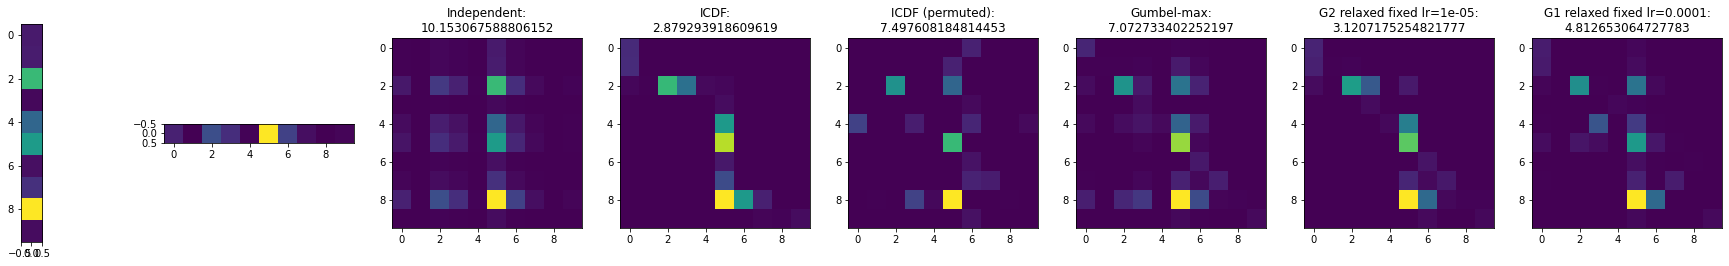

In [ ]:
experiment_util.compute_and_visualize_coupling_experiments([experiments[i] for i in lr_best_subset_fixed], [results[i] for i in lr_best_subset_fixed], 1)

#### Extract best learning rates

In [ ]:
best_lr_map = {}
for i in (lr_best_subset_fixed + lr_best_subset_independent + lr_best_subset_reverse):
  print(i, experiments[i].metadata)
  best_lr_map[experiments[i].metadata["is_gadget_2"], experiments[i].metadata["p_q_mode"]] = experiments[i].metadata["lr"]

4 {'lr': 1e-05, 'p_q_mode': 'fixed', 'is_gadget_2': True}
11 {'lr': 0.0001, 'p_q_mode': 'fixed', 'is_gadget_2': False}
20 {'lr': 0.001, 'p_q_mode': 'independent', 'is_gadget_2': True}
9 {'lr': 0.0001, 'p_q_mode': 'independent', 'is_gadget_2': False}
18 {'lr': 0.001, 'p_q_mode': 'reverse', 'is_gadget_2': True}
7 {'lr': 0.0001, 'p_q_mode': 'reverse', 'is_gadget_2': False}


### Phase 2: Retrain for multiple seeds with tuned learning rate

In [ ]:
S_dim = 10
experiments = []
for p_q_mode in ["reverse", "independent", "fixed"]:
  for is_gadget_2 in [True, False]:
    for train_seed in [1, 2, 3, 4, 5]:
      lr = best_lr_map[is_gadget_2, p_q_mode]
      ex = experiment_util.CouplingExperimentConfig(
        name=f"G{2 if is_gadget_2 else 1} relaxed {p_q_mode} lr={lr} seed={train_seed}",
        model=(
            gadget_2.GadgetTwoMLPPredictor(
                S_dim=10, Z_dim=20, hidden_features=[1024, 1024],
                relaxation_temperature=1.0, learn_prior=False)
            if is_gadget_2 else
            gadget_1.GadgetOneMLPPredictor(
                S_dim=10, hidden_features=[1024, 1024],
                relaxation_temperature=1.0)
        ),
        logit_pair_distribution_fn=functools.partial(
            softmax_uniform_logit_pair_distribution_fn,
            dim=S_dim,
            p_q_mode=p_q_mode),
        coupling_loss_matrix_fn=squared_loss_matrix_fn,
        inner_num_samples=16,
        batch_size=64,
        use_transpose=(not is_gadget_2),
        tx=optax.adam(lr),
        num_steps=50_000,
        print_every=2_500,
        metadata=dict(lr=lr, p_q_mode=p_q_mode, is_gadget_2=is_gadget_2, train_seed=train_seed),
      )
      experiments.append(ex)

In [ ]:
results = []
for ex in experiments:
  print("=" * 20)
  print(f"Training: {ex.name}")
  res = ex.train(jax.random.PRNGKey(ex.metadata["train_seed"]))
  time.sleep(0.1)
  client = jax.lib.xla_bridge.get_backend()
  client.defragment()
  results.append(res)

Training: G2 relaxed reverse lr=0.001 seed=1
0 [0.1716514413788153/s]: {'loss': 17.07481575012207}
1 [44.345689454653105/s]: {'loss': 16.428869247436523}
2 [45.09470922794078/s]: {'loss': 18.78879737854004}
4 [81.11675401783124/s]: {'loss': 16.432809829711914}
8 [144.78844261870654/s]: {'loss': 13.15888786315918}
16 [230.50375764237137/s]: {'loss': 15.356531143188477}
32 [325.1303934963131/s]: {'loss': 14.17373275756836}
64 [408.8775265872375/s]: {'loss': 14.87680435180664}
128 [473.4244596196174/s]: {'loss': 12.847692489624023}
256 [520.0972554155918/s]: {'loss': 12.418379783630371}
512 [536.8336020646565/s]: {'loss': 14.044510841369629}
1024 [552.4308164848154/s]: {'loss': 12.196905136108398}
2048 [556.5708052221901/s]: {'loss': 14.646544456481934}
2500 [547.1313386212175/s]: {'loss': 12.249279975891113}
4096 [560.4782678807987/s]: {'loss': 15.04683780670166}
5000 [552.0600880727586/s]: {'loss': 13.801310539245605}
7500 [525.7855687461813/s]: {'loss': 12.821038246154785}
8192 [522.09

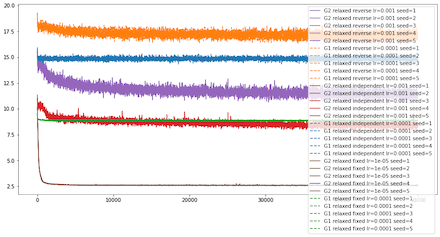

In [ ]:
plt.figure(figsize=(15,7))
WINDOW_SIZE = 25
for ex, res in zip(experiments, results):
  plt.plot(np.arange(0, ex.num_steps, WINDOW_SIZE),
           np.reshape([m["loss"] for m in res.all_metrics],
                    [-1, WINDOW_SIZE]).mean(-1),
           "-" if ex.metadata["is_gadget_2"] else "--",
           label=ex.name,
           color=mpl.cm.tab10(
               (3 if ex.metadata["is_gadget_2"] else 0)
               + {"independent": 0, "reverse":1, "fixed":2}[ex.metadata["p_q_mode"]]))
plt.legend()

### Evaluate each model for each seed

In [ ]:
scores_per_mode = {}
# Each p_q_mode is a separate column we want data form
for p_q_mode in ["reverse", "independent", "fixed"]:
  scores_per_mode[p_q_mode] = []
  # For each column, run five random evaluations. Each evaluation will itself
  # average over some number of logit pairs, but we will average over enough
  # so that the variance in this is minimal within each evaluation. For our
  # gadgets, each evaluation represents a separate training run with a separate
  # evaluation; for the baselines, we just redo the evaluation with a different
  # test set.
  for seed in [1, 2, 3, 4, 5]:
    print(p_q_mode, seed)
    sub_exps = []
    sub_res = []
    for ex, res in zip(experiments, results):
      if ex.metadata["p_q_mode"] == p_q_mode and ex.metadata["train_seed"] == seed:
        sub_exps.append(ex)
        sub_res.append(res)
    
    num_pairs = 10_000 if p_q_mode is not "fixed" else 1
    samples_per_pair = 1_000 if p_q_mode is not "fixed" else 100_000
    eval_results = experiment_util.evaluate_all(
        sub_exps,
        sub_res,
        seed=1000 + seed,
        num_pairs=num_pairs,
        samples_per_pair=samples_per_pair,
        loop_size=500)
    scores_per_mode[p_q_mode].append(eval_results)

reverse 1
reverse 2
reverse 3
reverse 4
reverse 5
independent 1
independent 2
independent 3
independent 4
independent 5
fixed 1
fixed 2
fixed 3
fixed 4
fixed 5


In [ ]:
scores_per_mode

{'reverse': [{'Independent': ('average: 21.3639, inner st.dev.: +/- 20.62, errorbars: +/- 0.1217',
                              DeviceArray(21.363926, dtype=float32),
                              DeviceArray(0.12168898, dtype=float32),
                              DeviceArray(20.621542, dtype=float32)),
              'ICDF': ('average: 12.6092, inner st.dev.: +/- 11.92, errorbars: +/- 0.1302',
                       DeviceArray(12.609152, dtype=float32),
                       DeviceArray(0.13017197, dtype=float32),
                       DeviceArray(11.9230175, dtype=float32)),
              'ICDF (permuted)': ('average: 20.9642, inner st.dev.: +/- 20.66, errorbars: +/- 0.1455',
                                  DeviceArray(20.964172, dtype=float32),
                                  DeviceArray(0.14546159, dtype=float32),
                                  DeviceArray(20.66472, dtype=float32)),
              'Gumbel-max': ('average: 18.8843, inner st.dev.: +/- 20.34, errorbars: +/- 0.1264',
                             DeviceArray(18.884254, dtype=float32),
                             DeviceArray(0.12635598, dtype=float32),
                             DeviceArray(20.34204, dtype=float32)),
              'G2 relaxed reverse lr=0.001 seed=1':
                ('average: 13.4887, inner st.dev.: +/- 13.24, errorbars: +/- 0.1334',
                 DeviceArray(13.488668, dtype=float32),
                 DeviceArray(0.13344897, dtype=float32),
                 DeviceArray(13.239265, dtype=float32)),
              'G1 relaxed reverse lr=0.0001 seed=1':
                ('average: 17.3937, inner st.dev.: +/- 18.6, errorbars: +/- 0.1215',
                 DeviceArray(17.393736, dtype=float32),
                 DeviceArray(0.12154795, dtype=float32),
                 DeviceArray(18.59577, dtype=float32))},
             {'Independent': ('average: 21.5004, inner st.dev.: +/- 20.66, errorbars: +/- 0.1224',
                              DeviceArray(21.50043, dtype=float32),
                              DeviceArray(0.12240016, dtype=float32),
                              DeviceArray(20.664627, dtype=float32)),
              'ICDF': ('average: 12.6706, inner st.dev.: +/- 12.01, errorbars: +/- 0.1311',
                       DeviceArray(12.670625, dtype=float32),
                       DeviceArray(0.13112766, dtype=float32),
                       DeviceArray(12.008648, dtype=float32)),
              'ICDF (permuted)': ('average: 21.1901, inner st.dev.: +/- 20.72, errorbars: +/- 0.1469',
                                  DeviceArray(21.190104, dtype=float32),
                                  DeviceArray(0.14690863, dtype=float32),
                                  DeviceArray(20.71581, dtype=float32)),
              'Gumbel-max': ('average: 18.9430, inner st.dev.: +/- 20.33, errorbars: +/- 0.1265',
                             DeviceArray(18.94298, dtype=float32),
                             DeviceArray(0.12647489, dtype=float32),
                             DeviceArray(20.331444, dtype=float32)),
              'G2 relaxed reverse lr=0.001 seed=2':
                ('average: 13.5027, inner st.dev.: +/- 13.31, errorbars: +/- 0.1342',
                 DeviceArray(13.502703, dtype=float32),
                 DeviceArray(0.13417827, dtype=float32),
                 DeviceArray(13.311537, dtype=float32)),
              'G1 relaxed reverse lr=0.0001 seed=2':
                ('average: 16.7102, inner st.dev.: +/- 17.66, errorbars: +/- 0.1224',
                 DeviceArray(16.710213, dtype=float32),
                 DeviceArray(0.1224412, dtype=float32),
                 DeviceArray(17.65919, dtype=float32))},
             {'Independent': ('average: 21.3441, inner st.dev.: +/- 20.51, errorbars: +/- 0.1217',
                              DeviceArray(21.344065, dtype=float32),
                              DeviceArray(0.12172244, dtype=float32),
                              DeviceArray(20.511889, dtype=float32)),
              'ICDF': ('average:

In [ ]:
def fix_name(name):
  lookups = {
    "Independent":"Independent",
    "ICDF":"CDF$^{-1}$",
    "ICDF (permuted)":"Permuted CDF$^{-1}$",
    "Gumbel-max":"Gumbel-max",
    "G1":"Gadget 1",
    "G2":"Gadget 2",
  }
  return lookups[name.split(" relaxed")[0]]


all_scores = {}
for p_q_mode in ["reverse", "independent", "fixed"]:
  scores = collections.defaultdict(list)
  for eval_sample in scores_per_mode[p_q_mode]:
    for name, (_, eval_average_for_seed, _, _) in eval_sample.items():
      if " seed" in name:
        name = name.split(" seed")[0]
      scores[name].append(eval_average_for_seed)
  all_scores[p_q_mode] = {fix_name(k):np.array(v) for k,v in scores.items()}

In [ ]:
all_scores

{'reverse': {'Independent': array([21.363926, 21.50043 , 21.344065, 21.254772, 21.222311], dtype=float32),
             'CDF$^{-1}$': array([12.609152, 12.670625, 12.701512, 12.481017, 12.479548], dtype=float32),
             'Permuted CDF$^{-1}$': array([20.964172, 21.190104, 21.145863, 20.885592, 20.800993], dtype=float32),
             'Gumbel-max': array([18.884254, 18.94298 , 18.900438, 18.739632, 18.730356], dtype=float32),
             'Gadget 2': array([13.488668 , 13.502703 , 13.599887 , 13.3832655, 13.3682375], dtype=float32),
             'Gadget 1': array([17.393736, 16.710213, 16.126501, 16.288496, 16.84675 ], dtype=float32)},
 'independent': {'Independent': array([16.508272, 16.518478, 16.497957, 16.50528 , 16.519663], dtype=float32),
                 'CDF$^{-1}$': array([8.150713, 8.144406, 8.125899, 8.14375 , 8.119367], dtype=float32),
                 'Permuted CDF$^{-1}$': array([15.701109, 15.782795, 15.674964, 15.753175, 15.683562], dtype=float32),
                 'Gumbel-max': array([14.027739, 14.024696, 14.012157, 14.026989, 14.030783], dtype=float32),
                 'Gadget 2': array([8.785703 , 8.758417 , 8.7387905, 8.790046 , 8.719542 ], dtype=float32),
                 'Gadget 1': array([14.039748 , 14.051689 , 14.0592165, 14.033333 , 14.068659 ], dtype=float32)},
 'fixed': {'Independent': array([10.153068, 10.153068, 10.153068, 10.153068, 10.153068], dtype=float32),
           'CDF$^{-1}$': array([2.879294, 2.879294, 2.879294, 2.879294, 2.879294], dtype=float32),
           'Permuted CDF$^{-1}$': array([7.497608, 7.497608, 7.497608, 7.497608, 7.497608], dtype=float32),
           'Gumbel-max': array([7.09031  , 7.05576  , 7.1221094, 7.07087  , 7.1116104], dtype=float32),
           'Gadget 2': array([3.1460903, 3.1315596, 3.1257203, 3.1410398, 3.1528099], dtype=float32),
           'Gadget 1': array([4.83077  , 4.81216  , 4.7808704, 4.27908  , 4.76273  ], dtype=float32)}}

### Build the table

In [ ]:
name_order = [
  "Independent",
  "CDF$^{-1}$",
  "Permuted CDF$^{-1}$",
  "Gumbel-max",
  "Gadget 1",
  "Gadget 2",
]

for name in name_order:
  parts = [name]
  parts.append(" & ")
  for p_q_mode in ["independent", "reverse"]: # "fixed",
    avg = np.mean(all_scores[p_q_mode][name])
    std = np.std(all_scores[p_q_mode][name])
    parts.append(f"{avg:.2f} $\pm$ {std:.2f}")
    parts.append(" & ")
  parts.pop()
  parts.append(" \\\\")
  print("".join(parts))

Independent & 16.51 $\pm$ 0.01 & 21.34 $\pm$ 0.10 \\
CDF$^{-1}$ & 8.14 $\pm$ 0.01 & 12.59 $\pm$ 0.09 \\
Permuted CDF$^{-1}$ & 15.72 $\pm$ 0.04 & 21.00 $\pm$ 0.15 \\
Gumbel-max & 14.02 $\pm$ 0.01 & 18.84 $\pm$ 0.09 \\
Gadget 1 & 14.05 $\pm$ 0.01 & 16.67 $\pm$ 0.45 \\
Gadget 2 & 8.76 $\pm$ 0.03 & 13.47 $\pm$ 0.09 \\


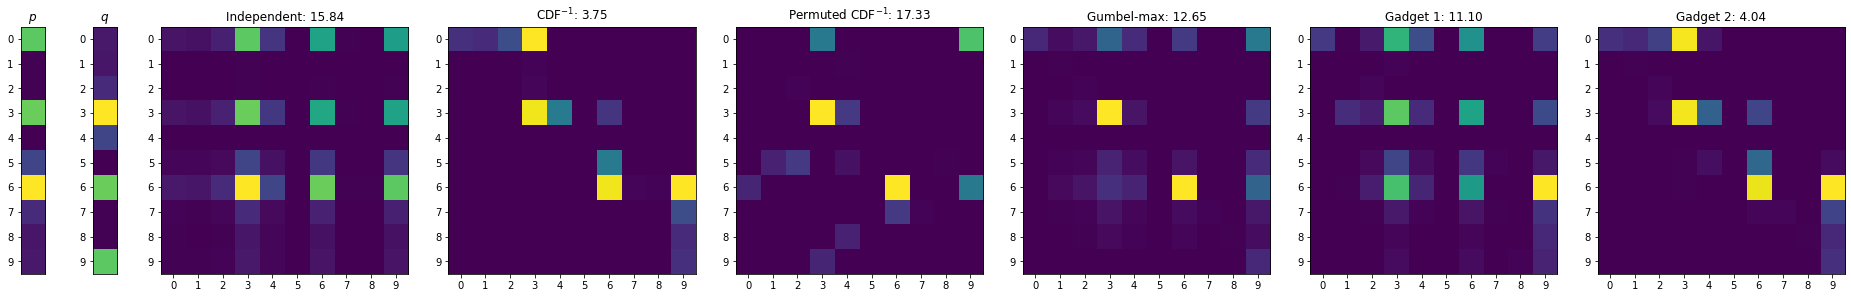

In [ ]:
vis_exs = []
vis_res = []
for ex, res in zip(experiments, results):
  if ex.metadata["p_q_mode"] == "reverse" and ex.metadata["train_seed"] == 1:
    vis_exs.append(ex)
    vis_res.append(res)

# vis_exs, vis_res = [experiments[i] for i in lr_best_subset_reverse], [results[i] for i in lr_best_subset_reverse]
(logits_1, logits_2), coupling_estimates = experiment_util.get_coupling_estimates(vis_exs, vis_res, 2)

loss_values = experiment_util.compute_coupling_losses(experiments, logits_1, logits_2, coupling_estimates)

ncouplings =  len(coupling_estimates)
ncols = 2 + ncouplings
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(2 + 4*ncouplings, 4), gridspec_kw={'width_ratios': [2,2] + [11]*ncouplings})
axs[0].imshow(jnp.exp(logits_1)[:, None], vmin=0)
axs[0].set_xticks([])
axs[0].set_yticks(np.arange(10))
axs[0].set_title("$p$")
axs[1].imshow(jnp.exp(logits_2)[:, None], vmin=0)
axs[1].set_xticks([])
axs[1].set_yticks(np.arange(10))
axs[1].set_title("$q$")
for j, (name, coupling) in enumerate(sorted(coupling_estimates.items(), key=lambda t: fix_order(t[0]))):
  axs[j+2].imshow(coupling, vmin=0)
  axs[j+2].set_title(f"{fix_name(name)}: {loss_values[name]:.2f}")
  axs[j+2].set_xticks(np.arange(10))
  axs[j+2].set_yticks(np.arange(10))
fig.tight_layout()